In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

2024-04-14 15:27:02.394169: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 15:27:02.394260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 15:27:02.394282: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 15:27:02.401299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/envs/btp/lib/python3.9/site-packages/te

TensorFlow Version 2.14.1


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 7
NUM_CLASSES=39

In [3]:
IMAGES_PATH = 'images/'
image_category_mapping = {}
# Create a list of all the images in images/category

for subdir, _, files in os.walk(IMAGES_PATH):
    directory_name = os.path.basename(subdir)
    disease_name = directory_name.split("__")[-1]
    if not directory_name:
      continue
    if disease_name[0]=='_':
      disease_name = disease_name[1:]
    for file in files:
            image_path = os.path.join(subdir, file)
            image_category_mapping[image_path]=disease_name
# unique_diseases = list(set([image_category_mapping[i] for i in image_category_mapping]))
# for i in image_category_mapping:
#   image_category_mapping[i]=unique_diseases.index(image_category_mapping[i])


In [4]:
import random
from sklearn.model_selection import train_test_split


image_paths = list(image_category_mapping.keys())
NUM_IMAGES = len(image_paths)
random.seed(2)  # For reproducibility
random.shuffle(image_paths)
#image_paths=image_paths[:NUM_IMAGES]  #Take a subset of images

# Split the keys into train, validation, and test sets
TEST_SIZE = int(NUM_IMAGES*0.2)
TRAIN_SIZE = int(NUM_IMAGES*0.8)
VAL_SIZE = int(TRAIN_SIZE*0.2)
# TRAIN_SIZE = NUM_IMAGES - TEST_SIZE -VAL_SIZE
train_paths = image_paths[:TRAIN_SIZE]
val_paths=image_paths[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]
test_paths = image_paths[NUM_IMAGES-TEST_SIZE:]

DF_TRAIN = pd.DataFrame({'filename': train_paths, 'label': [image_category_mapping[path] for path in train_paths]})
DF_TEST = pd.DataFrame({'filename': test_paths, 'label': [image_category_mapping[path] for path in test_paths]})

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range = [0.5, 1.5],
        fill_mode='nearest',
        validation_split=0.2
        )

In [6]:


train_gen = train_datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        x_col = 'filename',
                                        y_col = 'label',
                                        subset = 'training',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        validation_split = 0.2,
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

val_datagen = ImageDataGenerator()

valid_gen = train_datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        x_col = 'filename',
                                        y_col = 'label',
                                        subset = 'validation',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(dataframe = DF_TEST,
                                       x_col = 'filename',
                                       y_col = 'label',
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = 'categorical',
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 61356 validated image filenames belonging to 39 classes.
Found 15338 validated image filenames belonging to 39 classes.
Found 19173 validated image filenames belonging to 39 classes.


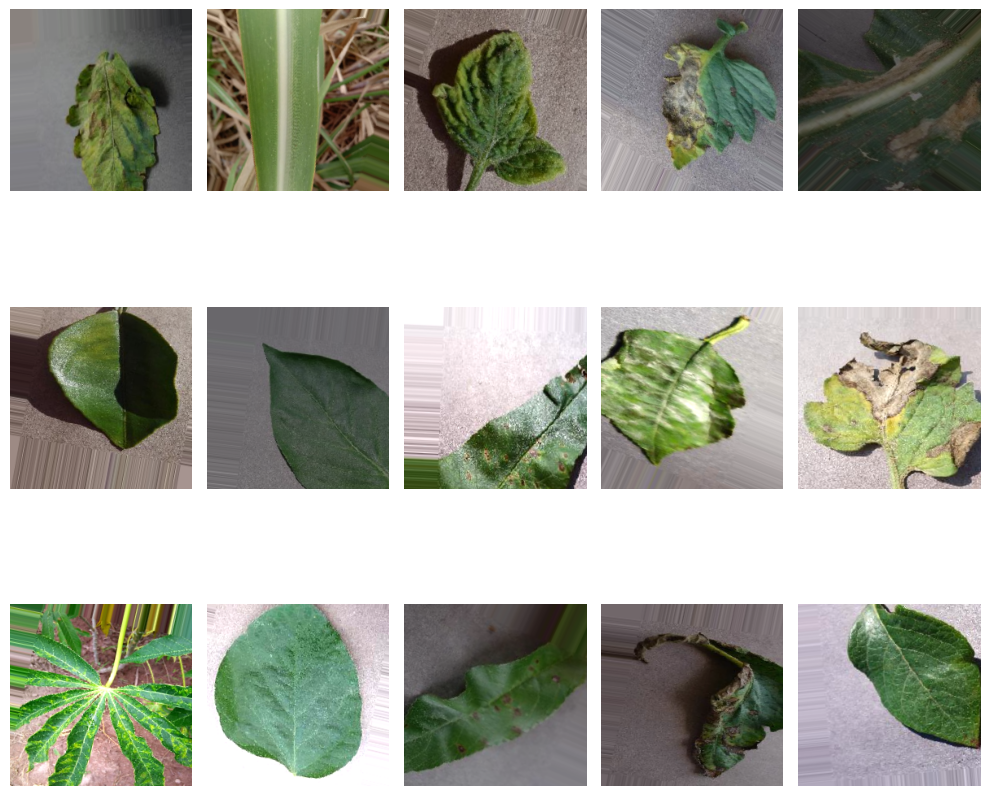

In [7]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
import sys
# !{sys.executable} -m pip install --quiet vit-keras
# !{sys.executable} -m pip install --quiet opencv-python
# ! apt-get update && apt-get install libgl1 -y
from vit_keras import vit

In [9]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

2024-04-14 15:27:15.677295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38583 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


In [10]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(NUM_CLASSES, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Bat  (None, 11)                44        
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 39)         

In [11]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

history = model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model.h5')

Epoch 1/7


2024-04-14 15:27:44.700623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


3834/3834 [==============================] - ETA: 0s - loss: 2.3882 - accuracy: 0.6849
Epoch 1: val_accuracy improved from -inf to 0.85445, saving model to ./model.hdf5
3834/3834 [==============================] - 906s 230ms/step - loss: 2.3882 - accuracy: 0.6849 - val_loss: 1.7237 - val_accuracy: 0.8544 - lr: 1.0000e-04
Epoch 2/7
3834/3834 [==============================] - ETA: 0s - loss: 1.7169 - accuracy: 0.8492
Epoch 2: val_accuracy improved from 0.85445 to 0.88257, saving model to ./model.hdf5
3834/3834 [==============================] - 870s 227ms/step - loss: 1.7169 - accuracy: 0.8492 - val_loss: 1.5722 - val_accuracy: 0.8826 - lr: 1.0000e-04
Epoch 3/7
3834/3834 [==============================] - ETA: 0s - loss: 1.5996 - accuracy: 0.8750
Epoch 3: val_accuracy improved from 0.88257 to 0.90207, saving model to ./model.hdf5
3834/3834 [==============================] - 829s 216ms/step - loss: 1.5996 - accuracy: 0.8750 - val_loss: 1.5075 - val_accuracy: 0.9021 - lr: 1.0000e-04
Epoch

600/600 [==============================] - 42s 67ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.96      0.92      0.94        60
           2       0.78      0.76      0.77       515
           3       0.98      0.99      0.98      1068
           4       0.97      0.58      0.72       116
           5       0.99      0.99      0.99       438
           6       0.99      0.99      0.99       355
           7       0.99      0.98      0.99       308
           8       0.98      0.99      0.99       356
           9       0.48      0.63      0.54       461
          10       1.00      1.00      1.00      1109
          11       0.99      1.00      0.99       272
          12       0.97      0.96      0.97       751
          13       0.87      0.93      0.90        97
          14       0.95      0.91      0.93        82
          15       0.62      0.29      0.40       466
          16       0.90 

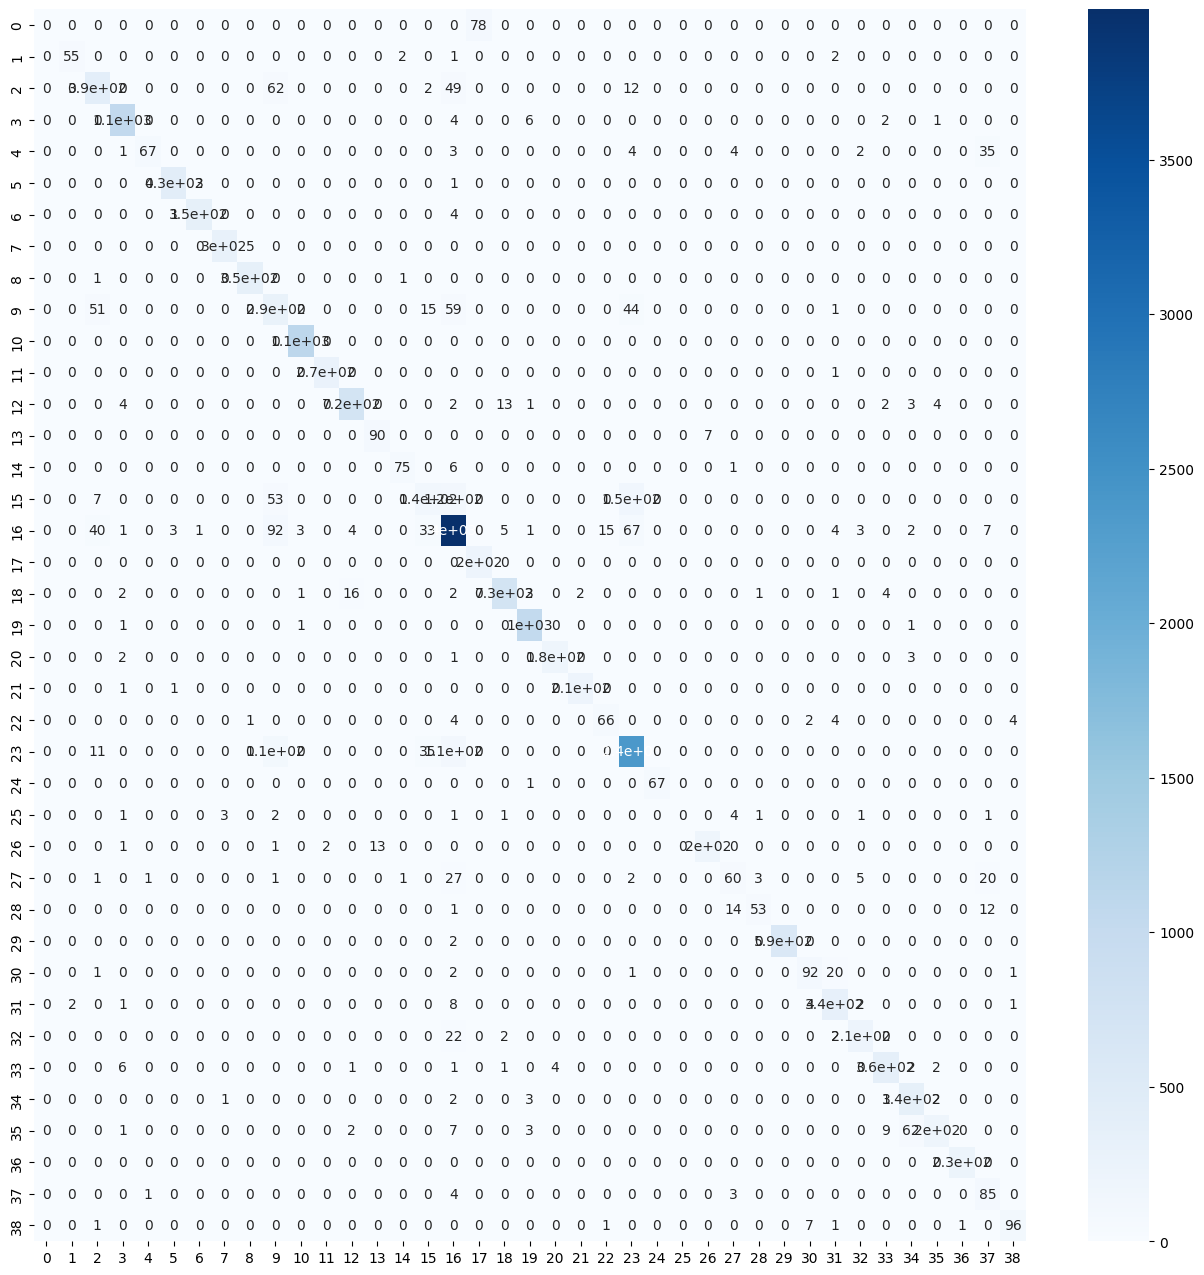

In [12]:
predicted_classes = np.argmax(model.predict(test_gen, steps = test_gen.n // test_gen.batch_size + 1), axis = 1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))